# Modelo para Produção de Celulase
## Angarita et al. 2015

Tradução do código Scilab para Python

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import pandas as pd

## Dados Experimentais

In [24]:
# Dados experimentais
# 20% sólidos e 10 FPU/g
dados = np.array([
    [1.0, 5.46, 0.00, 2.50],
    [2.0, 5.93, 0.00, 3.30],
    [4.0, 11.87, 0.00, 3.49],
    [6.0, 13.99, 0.00, 3.90],
    [8.0, 22.14, 0.47, 5.64],
    [12.0, 24.47, 0.51, 5.76],
    [24.0, 38.97, 0.96, 8.15],
    [48.0, 51.08, 1.28, 9.29],
    [72.0, 70.66, 2.19, 11.32],
    [96.0, 84.52, 0.11, 11.99]
])

# 10% sólidos e 10FPU/g [tempo G G2 X]
dados1 = np.array([
    [1, 4.30, 0.2295, 2.2004],
    [2, 6.83, 0.2981, 3.2317],
    [6, 15.05, 0.4533, 5.0717],
    [8, 20.49, 0.3853, 4.6835],
    [12, 21.02, 0.5157, 5.6440],
    [24, 23.31, 0.4363, 9.6220],
    [48, 35.19, 0.7423, 8.1657],
    [72, 37.86, 0.5667, 7.3837],
    [96, 38.5, 0.3060, 7.9050]
])

# 15% sólidos e 10FPU/g [tempo G G2 X]
dados2 = np.array([
    [0, 0.0, 0.0, 0.0],
    [1, 8.77, 0.17, 1.43],
    [2, 13.36, 0.37, 2.01],
    [4, 23.09, 0.69, 2.83],
    [6, 28.86, 0.82, 3.20],
    [8, 33.10, 0.92, 3.50],
    [12, 37.27, 1.05, 3.83],
    [24, 45.35, 1.41, 4.46],
    [48, 53.56, 1.08, 7.71],
    [72, 55.91, 0.95, 7.94],
    [96, 57.91, 0.93, 8.36]
])

## Definição dos Parâmetros do Modelo

In [25]:
# Configuração dos dados para o modelo
S0 = 150.0              # Carregamento de sólidos (Palha de cana-de-açúcar pré-tratada)
Cellulose = 0.66        # Conteúdo de celulose (0-1, adimensional)
Hemicellulose = 0.083   # Conteúdo de hemicelulose (0-1, adimensional)
Lignin = 0.257          # Conteúdo de lignina (0-1, adimensional)
Glucose = 0             # Concentração de glicose (g/L)
Cellobiose = 0          # Concentração de celobiose (g/L)
Xylose = 0              # Concentração de xilose (g/L)

alfa = 1.0
E_T = 0.175             # Concentração total de enzima (g/L)

# Parâmetros
k_1r = 0.177
k_2r = 8.81
k_3r = 201.0
k_4r = 16.34

k_11G2 = 0.402
k_11G = 2.71
k_11X = 2.15
k_21G2 = 119.6
k_21G = 4.69
k_21X = 0.095
k_3M = 26.6
k_31G = 11.06
k_31X = 1.023

k_41G2 = 16.25
k_41G = 4.0
k_41X = 154.0

k_ad = 7.16
E_max = 8.32/1000

## Cálculo da Enzima Livre e Adsorvida

In [26]:
def enzyme_equation(E_F, S):
    """Função para calcular o equilíbrio enzimático"""
    E_B = E_T - E_F
    return E_max * k_ad * E_F / (1 + k_ad * E_F) - E_B / S

# Condições iniciais para resolver a equação da enzima
S = S0
E_F_initial = 0.1

# Resolver para E_F
E_F = fsolve(lambda x: enzyme_equation(x, S), E_F_initial)[0]
E_B = E_T - E_F

print(f"Enzima livre inicial (E_F): {E_F:.4f} g/L")
print(f"Enzima adsorvida inicial (E_B): {E_B:.4f} g/L")

Enzima livre inicial (E_F): 0.0198 g/L
Enzima adsorvida inicial (E_B): 0.1552 g/L


## Sistema de Equações Diferenciais

In [27]:
def chemical_system(t, y):
    """Sistema de equações diferenciais para o modelo de hidrólise"""
    
    # Variáveis de estado
    C = y[0]    # Celulose (g/L)
    G2 = y[1]   # Celobiose (g/L)
    G = y[2]    # Glicose (g/L)
    H = y[3]    # Hemicelulose (g/L)
    X = y[4]    # Xilose (g/L)
    S = y[5]    # Biomassa (g/L)
    E_B = y[6]  # Enzima adsorvida na biomassa
    E_F = y[7]  # Enzima livre
    
    # Fator de resistência
    R_S = alfa * S / S0
    
    # Taxas de reação
    r1 = k_1r * (E_B * C / S) * R_S * C / (1 + G2/k_11G2 + G/k_11G + X/k_11X)  # Eq. 5
    r2 = k_2r * (E_B * C / S) * R_S * C / (1 + G2/k_21G2 + G/k_21G + X/k_21X)  # Eq. 6
    r3 = k_3r * E_F * G2 / (k_3M * (1 + G/k_31G + X/k_31X) + G2)              # Eq. 7
    r4 = k_4r * (E_B * H / S) * R_S * H / (1 + G2/k_41G2 + G/k_41G + X/k_41X)  # Eq. 8
    
    # Sistema de equações diferenciais
    dCdt = -r1 - r2                    # Balanço de celulose
    dG2dt = 1.056 * r1 - r3            # Balanço de celobiose
    dGdt = 1.111 * r2 + 1.053 * r3     # Balanço de glicose
    dHdt = -r4                         # Balanço de hemicelulose
    dXdt = 1.136 * r4                  # Balanço de xilose
    dSdt = -r1 - r2 - r4               # Balanço de biomassa
    
    # Equações algébricas para as enzimas (derivadas = 0)
    dE_Bdt = 0
    dE_Fdt = 0
    
    return [dCdt, dG2dt, dGdt, dHdt, dXdt, dSdt, dE_Bdt, dE_Fdt]

## Condições Iniciais e Integração

In [28]:
# Condições iniciais
t0 = 0              # Tempo inicial (h)
tn = 96.0           # Tempo final (h)
t_span = (t0, tn)
t_eval = np.linspace(t0, tn, 97)  # Pontos de avaliação

# Lignina
Lig = Lignin * S0

# Condições iniciais [C, G2, G, H, X, S, E_B, E_F]
y0 = [
    S0 * Cellulose,    # Celulose inicial
    Cellobiose,        # Celobiose inicial
    Glucose,           # Glicose inicial
    S0 * Hemicellulose, # Hemicelulose inicial
    Xylose,            # Xilose inicial
    S0,                # Biomassa inicial
    E_B,               # Enzima adsorvida inicial
    E_F                # Enzima livre inicial
]

print("Condições iniciais:")
print(f"Celulose: {y0[0]:.2f} g/L")
print(f"Celobiose: {y0[1]:.2f} g/L")
print(f"Glicose: {y0[2]:.2f} g/L")
print(f"Hemicelulose: {y0[3]:.2f} g/L")
print(f"Xilose: {y0[4]:.2f} g/L")
print(f"Biomassa: {y0[5]:.2f} g/L")
print(f"Enzima adsorvida: {y0[6]:.4f} g/L")
print(f"Enzima livre: {y0[7]:.4f} g/L")

Condições iniciais:
Celulose: 99.00 g/L
Celobiose: 0.00 g/L
Glicose: 0.00 g/L
Hemicelulose: 12.45 g/L
Xilose: 0.00 g/L
Biomassa: 150.00 g/L
Enzima adsorvida: 0.1552 g/L
Enzima livre: 0.0198 g/L


## Solução do Sistema

In [29]:
# Resolver o sistema de equações diferenciais
sol = solve_ivp(chemical_system, t_span, y0, t_eval=t_eval, method='LSODA', rtol=1e-8)

# Extrair resultados
t_result = sol.t
C_result = sol.y[0]
G2_result = sol.y[1]
G_result = sol.y[2]
H_result = sol.y[3]
X_result = sol.y[4]
S_result = sol.y[5]
EB_result = sol.y[6]
EF_result = sol.y[7]

print(f"Integração concluída. Status: {sol.message}")
print(f"Número de pontos: {len(t_result)}")

Integração concluída. Status: The solver successfully reached the end of the integration interval.
Número de pontos: 97


## Gráficos dos Resultados

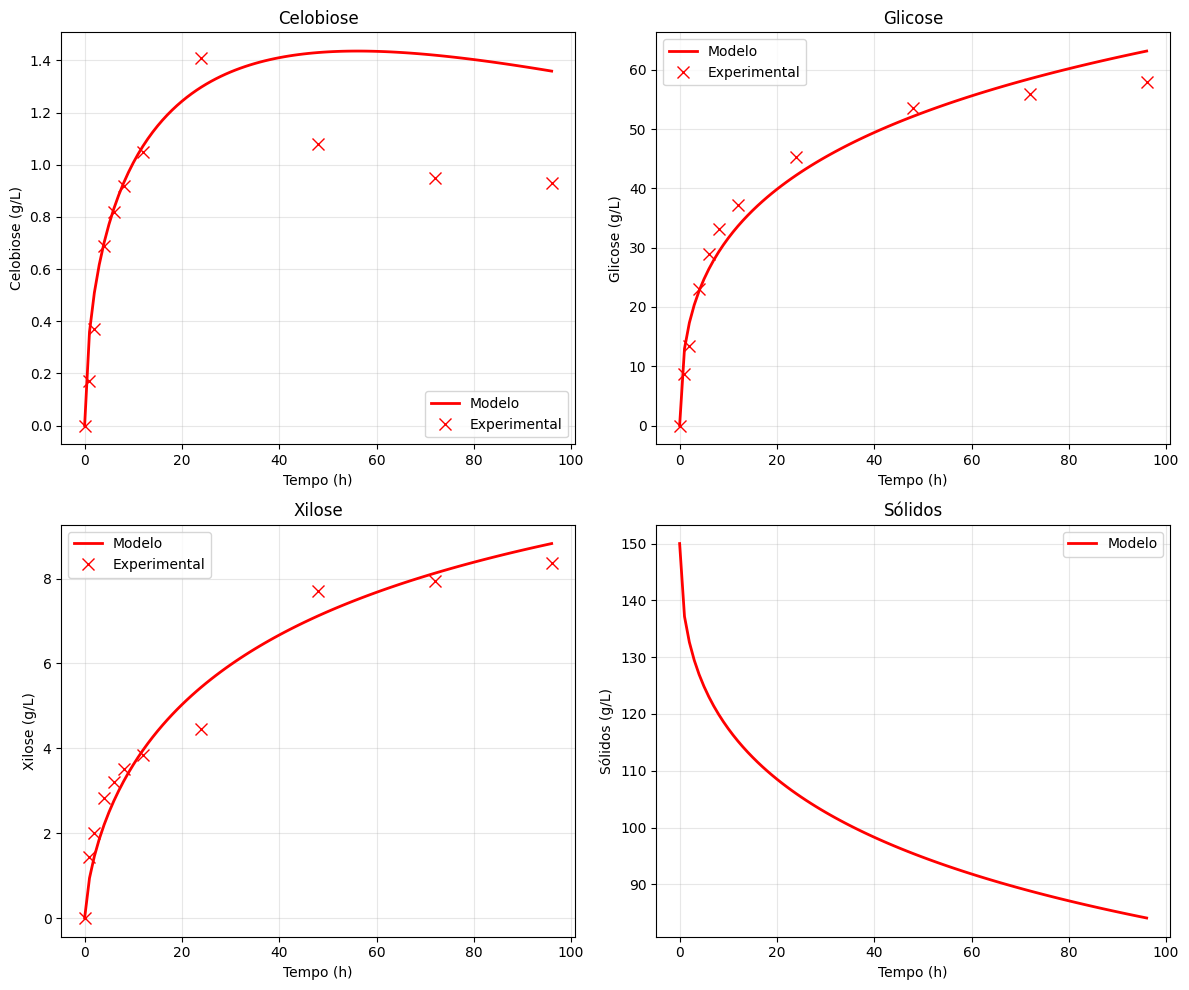

In [30]:
# Criar gráficos
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico 1: Celobiose
ax1.plot(t_result, G2_result, 'r-', label='Modelo', linewidth=2)
ax1.plot(dados2[:, 0], dados2[:, 2], 'rx', label='Experimental', markersize=8)
ax1.set_xlabel('Tempo (h)')
ax1.set_ylabel('Celobiose (g/L)')
ax1.set_title('Celobiose')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Glicose
ax2.plot(t_result, G_result, 'r-', label='Modelo', linewidth=2)
ax2.plot(dados2[:, 0], dados2[:, 1], 'rx', label='Experimental', markersize=8)
ax2.set_xlabel('Tempo (h)')
ax2.set_ylabel('Glicose (g/L)')
ax2.set_title('Glicose')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Xilose
ax3.plot(t_result, X_result, 'r-', label='Modelo', linewidth=2)
ax3.plot(dados2[:, 0], dados2[:, 3], 'rx', label='Experimental', markersize=8)
ax3.set_xlabel('Tempo (h)')
ax3.set_ylabel('Xilose (g/L)')
ax3.set_title('Xilose')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Sólidos
ax4.plot(t_result, S_result, 'r-', label='Modelo', linewidth=2)
ax4.set_xlabel('Tempo (h)')
ax4.set_ylabel('Sólidos (g/L)')
ax4.set_title('Sólidos')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Análise dos Resultados

In [31]:
# Criar DataFrame com os resultados
results_df = pd.DataFrame({
    'Tempo (h)': t_result,
    'Celulose (g/L)': C_result,
    'Celobiose (g/L)': G2_result,
    'Glicose (g/L)': G_result,
    'Hemicelulose (g/L)': H_result,
    'Xilose (g/L)': X_result,
    'Sólidos (g/L)': S_result,
    'Enzima Adsorvida (g/L)': EB_result,
    'Enzima Livre (g/L)': EF_result
})

# Mostrar alguns pontos importantes
key_times = [0, 24, 48, 72, 96]
print("Resultados em tempos-chave:")
for time in key_times:
    idx = np.argmin(np.abs(t_result - time))
    print(f"\nTempo: {t_result[idx]:.1f} h")
    print(f"  Glicose: {G_result[idx]:.2f} g/L")
    print(f"  Celobiose: {G2_result[idx]:.2f} g/L")
    print(f"  Xilose: {X_result[idx]:.2f} g/L")
    print(f"  Sólidos: {S_result[idx]:.2f} g/L")

Resultados em tempos-chave:

Tempo: 0.0 h
  Glicose: 0.00 g/L
  Celobiose: 0.00 g/L
  Xilose: 0.00 g/L
  Sólidos: 150.00 g/L

Tempo: 24.0 h
  Glicose: 42.25 g/L
  Celobiose: 1.30 g/L
  Xilose: 5.44 g/L
  Sólidos: 105.95 g/L

Tempo: 48.0 h
  Glicose: 52.17 g/L
  Celobiose: 1.43 g/L
  Xilose: 7.12 g/L
  Sólidos: 95.42 g/L

Tempo: 72.0 h
  Glicose: 58.50 g/L
  Celobiose: 1.42 g/L
  Xilose: 8.13 g/L
  Sólidos: 88.84 g/L

Tempo: 96.0 h
  Glicose: 63.18 g/L
  Celobiose: 1.36 g/L
  Xilose: 8.82 g/L
  Sólidos: 84.08 g/L


## Conversão e Rendimentos

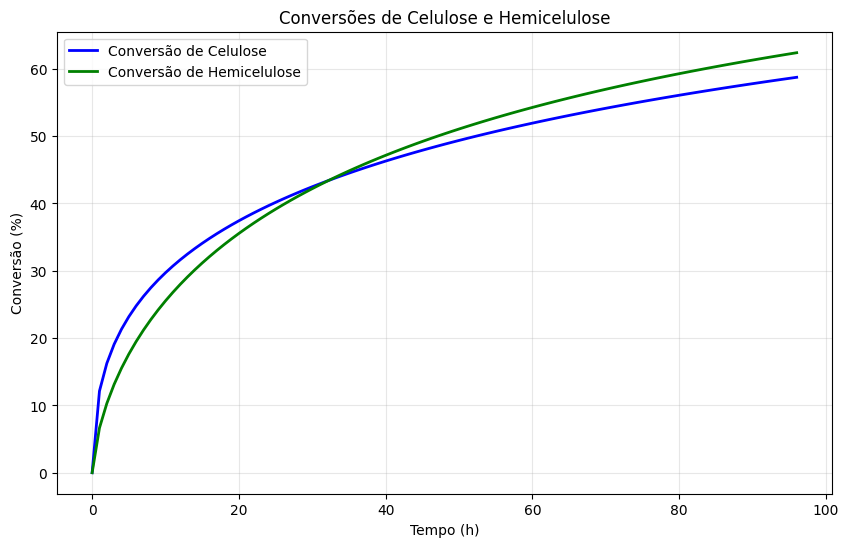

Conversão final de celulose: 58.7%
Conversão final de hemicelulose: 62.4%
Concentração final de glicose: 63.18 g/L
Concentração final de xilose: 8.82 g/L


In [32]:
# Calcular conversões
conversao_celulose = (1 - C_result / (S0 * Cellulose)) * 100
conversao_hemicelulose = (1 - H_result / (S0 * Hemicellulose)) * 100

# Gráfico de conversões
plt.figure(figsize=(10, 6))
plt.plot(t_result, conversao_celulose, 'b-', label='Conversão de Celulose', linewidth=2)
plt.plot(t_result, conversao_hemicelulose, 'g-', label='Conversão de Hemicelulose', linewidth=2)
plt.xlabel('Tempo (h)')
plt.ylabel('Conversão (%)')
plt.title('Conversões de Celulose e Hemicelulose')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Conversão final de celulose: {conversao_celulose[-1]:.1f}%")
print(f"Conversão final de hemicelulose: {conversao_hemicelulose[-1]:.1f}%")
print(f"Concentração final de glicose: {G_result[-1]:.2f} g/L")
print(f"Concentração final de xilose: {X_result[-1]:.2f} g/L")

Carregando dados experimentais 15%-10FPU do arquivo CSV...
Dados 15%-10FPU carregados: 11 pontos temporais
Tempos: [ 0  1  2  4  6  8 12 24 48 72 96]
Glicose: [ 0.    8.77 13.36 23.09 28.86 33.1  37.27 45.35 53.56 55.91 57.91]
Xilose: [0.   1.43 2.01 2.83 3.2  3.5  3.83 4.46 7.71 7.94 8.36]
Celobiose: [0.   0.17 0.37 0.69 0.82 0.92 1.05 1.41 1.08 0.95 0.93]


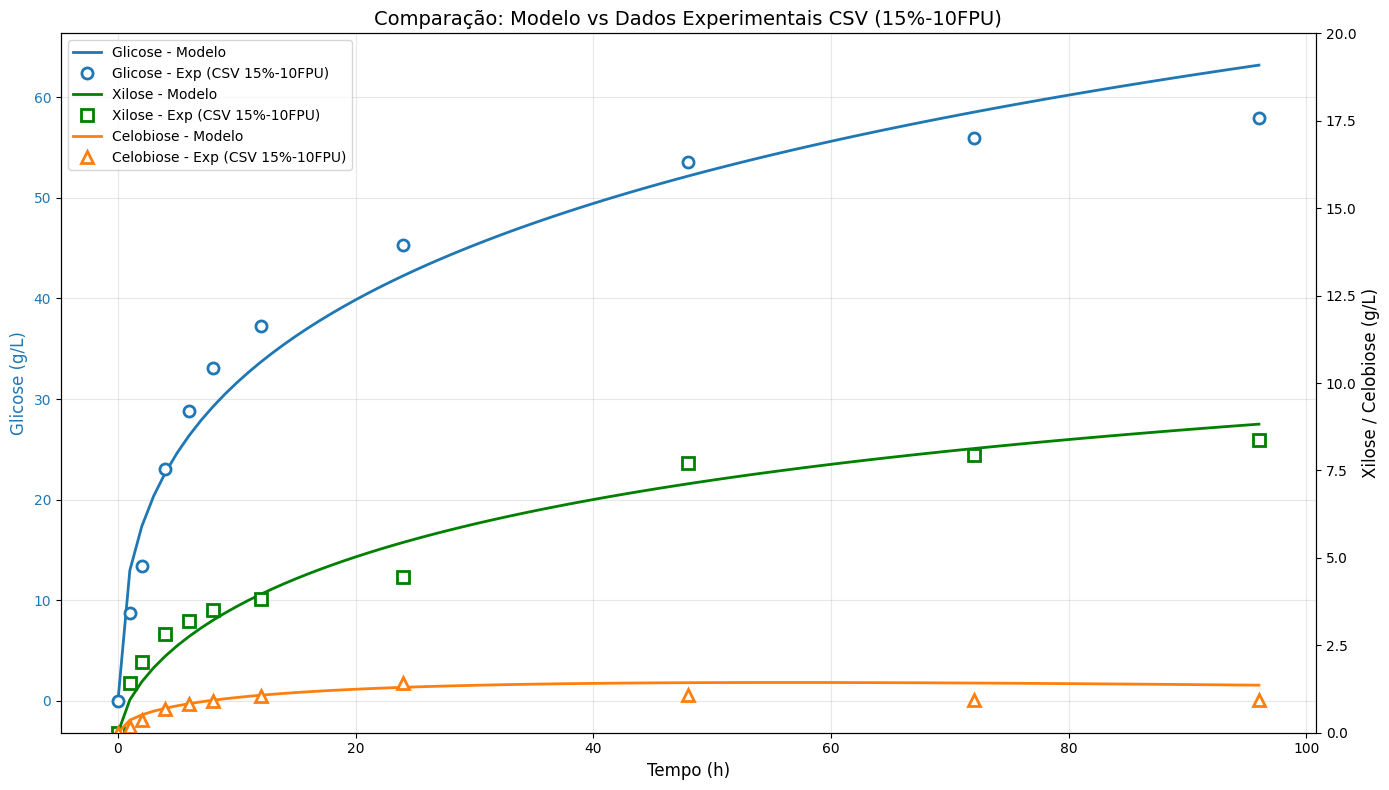


Comparação quantitativa (Modelo vs Experimental CSV):
Tempo (h)  Glicose (Exp)   Glicose (Mod)   Erro (%)  
------------------------------------------------------------
0.0        0.00            0.00            0.0       
1.0        8.77            12.97           47.8      
2.0        13.36           17.33           29.7      
4.0        23.09           22.71           1.6       
6.0        28.86           26.39           8.6       
8.0        33.10           29.25           11.6      
12.0       37.27           33.66           9.7       
24.0       45.35           42.25           6.8       
48.0       53.56           52.17           2.6       
72.0       55.91           58.50           4.6       
96.0       57.91           63.18           9.1       

Tempo (h)  Xilose (Exp)    Xilose (Mod)    Erro (%)  
------------------------------------------------------------
0.0        0.00            0.00            0.0       
1.0        1.43            0.94            34.3      
2.0        2

In [33]:
# Carregamento e plotagem dos dados experimentais 15%-10FPU do arquivo CSV
print("Carregando dados experimentais 15%-10FPU do arquivo CSV...")

# Leitura do arquivo CSV
try:
    df_csv = pd.read_csv('BEPE FAPESP/Dados Angarita.csv', sep=',')
    df_csv = df_csv.rename(columns=lambda x: x.strip())
    
    # Extrair dados 15%-10FPU
    tempo_csv = df_csv['Tempo [h]'].values
    glicose_exp = pd.to_numeric(df_csv['Glicose [g/L] 15%-10FPU'], errors='coerce').values
    xilose_exp = pd.to_numeric(df_csv['Xilose [g/L] 15%-10FPU'], errors='coerce').values
    celobiose_exp = pd.to_numeric(df_csv['Celobiose [g/L] 15%-10FPU'], errors='coerce').values
    
    # Remover valores NaN
    mask_validos = ~np.isnan(glicose_exp) & ~np.isnan(xilose_exp) & ~np.isnan(celobiose_exp)
    tempo_exp = tempo_csv[mask_validos]
    glicose_exp = glicose_exp[mask_validos]
    xilose_exp = xilose_exp[mask_validos]
    celobiose_exp = celobiose_exp[mask_validos]
    
    print(f"Dados 15%-10FPU carregados: {len(tempo_exp)} pontos temporais")
    print(f"Tempos: {tempo_exp}")
    print(f"Glicose: {glicose_exp}")
    print(f"Xilose: {xilose_exp}")
    print(f"Celobiose: {celobiose_exp}")
    
    # Criar gráfico comparativo com dados do CSV
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Glicose no eixo esquerdo
    ax1.plot(t_result, G_result, '-', label='Glicose - Modelo', color='tab:blue', linewidth=2)
    ax1.plot(tempo_exp, glicose_exp, 'o', label='Glicose - Exp (CSV 15%-10FPU)', color='tab:blue', markersize=8, markerfacecolor='white', markeredgewidth=2)
    ax1.set_xlabel('Tempo (h)', fontsize=12)
    ax1.set_ylabel('Glicose (g/L)', color='tab:blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)
    
    # Xilose e Celobiose no eixo direito
    ax2 = ax1.twinx()
    ax2.plot(t_result, X_result, '-', label='Xilose - Modelo', color='green', linewidth=2)
    ax2.plot(tempo_exp, xilose_exp, 's', label='Xilose - Exp (CSV 15%-10FPU)', color='green', markersize=8, markerfacecolor='white', markeredgewidth=2)
    ax2.plot(t_result, G2_result, '-', label='Celobiose - Modelo', color='tab:orange', linewidth=2)
    ax2.plot(tempo_exp, celobiose_exp, '^', label='Celobiose - Exp (CSV 15%-10FPU)', color='tab:orange', markersize=8, markerfacecolor='white', markeredgewidth=2)
    ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim(0, 20)
    
    # Legendas combinadas
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.title('Comparação: Modelo vs Dados Experimentais CSV (15%-10FPU)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Comparação quantitativa
    print("\nComparação quantitativa (Modelo vs Experimental CSV):")
    print("="*60)
    
    # Interpolar modelo nos tempos experimentais
    G_modelo_interp = np.interp(tempo_exp, t_result, G_result)
    X_modelo_interp = np.interp(tempo_exp, t_result, X_result)
    G2_modelo_interp = np.interp(tempo_exp, t_result, G2_result)
    
    print(f"{'Tempo (h)':<10} {'Glicose (Exp)':<15} {'Glicose (Mod)':<15} {'Erro (%)':<10}")
    print("-" * 60)
    for i in range(len(tempo_exp)):
        erro_G = abs(G_modelo_interp[i] - glicose_exp[i]) / glicose_exp[i] * 100 if glicose_exp[i] != 0 else 0
        print(f"{tempo_exp[i]:<10.1f} {glicose_exp[i]:<15.2f} {G_modelo_interp[i]:<15.2f} {erro_G:<10.1f}")
    
    print(f"\n{'Tempo (h)':<10} {'Xilose (Exp)':<15} {'Xilose (Mod)':<15} {'Erro (%)':<10}")
    print("-" * 60)
    for i in range(len(tempo_exp)):
        erro_X = abs(X_modelo_interp[i] - xilose_exp[i]) / xilose_exp[i] * 100 if xilose_exp[i] != 0 else 0
        print(f"{tempo_exp[i]:<10.1f} {xilose_exp[i]:<15.2f} {X_modelo_interp[i]:<15.2f} {erro_X:<10.1f}")
    
    # Calcular erro médio
    erro_medio_G = np.mean([abs(G_modelo_interp[i] - glicose_exp[i]) / glicose_exp[i] * 100 
                           for i in range(len(tempo_exp)) if glicose_exp[i] != 0])
    erro_medio_X = np.mean([abs(X_modelo_interp[i] - xilose_exp[i]) / xilose_exp[i] * 100 
                           for i in range(len(tempo_exp)) if xilose_exp[i] != 0])
    
    print(f"\nErro médio absoluto:")
    print(f"Glicose: {erro_medio_G:.1f}%")
    print(f"Xilose: {erro_medio_X:.1f}%")
    
except Exception as e:
    print(f"Erro ao carregar dados do CSV: {e}")
    print("Usando dados já definidos no notebook...")
    
    # Plotar com dados já existentes (dados2)
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Glicose no eixo esquerdo
    ax1.plot(t_result, G_result, '-', label='Glicose - Modelo', color='tab:blue', linewidth=2)
    ax1.plot(dados2[:, 0], dados2[:, 1], 'o', label='Glicose - Exp (dados2)', color='tab:blue', markersize=8, markerfacecolor='white', markeredgewidth=2)
    ax1.set_xlabel('Tempo (h)', fontsize=12)
    ax1.set_ylabel('Glicose (g/L)', color='tab:blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)
    
    # Xilose e Celobiose no eixo direito
    ax2 = ax1.twinx()
    ax2.plot(t_result, X_result, '-', label='Xilose - Modelo', color='green', linewidth=2)
    ax2.plot(dados2[:, 0], dados2[:, 3], 's', label='Xilose - Exp (dados2)', color='green', markersize=8, markerfacecolor='white', markeredgewidth=2)
    ax2.plot(t_result, G2_result, '-', label='Celobiose - Modelo', color='tab:orange', linewidth=2)
    ax2.plot(dados2[:, 0], dados2[:, 2], '^', label='Celobiose - Exp (dados2)', color='tab:orange', markersize=8, markerfacecolor='white', markeredgewidth=2)
    ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim(0, 20)
    
    # Legendas combinadas
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.title('Comparação: Modelo vs Dados Experimentais (15%-10FPU)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Modelo Completo de Hidrólise Enzimática - Execução Única

Esta célula contém o modelo completo de hidrólise enzimática em um único bloco executável. Inclui:
- Carregamento e limpeza de dados experimentais do CSV
- Definição de todos os parâmetros do modelo
- Sistema de equações diferenciais ordinárias (ODEs)
- Simulação numérica
- Plotagem comparativa entre modelo e dados experimentais
- Análise de erro quantitativa

Execute esta célula para obter a análise completa.

MODELO DE HIDRÓLISE ENZIMÁTICA - ANGARITA ET AL. 2015

1. CARREGANDO DADOS EXPERIMENTAIS...
✓ Dados 15%-10FPU carregados: 11 pontos temporais

2. DEFININDO PARÂMETROS DO MODELO...
✓ Parâmetros definidos

3. SISTEMA DE ODEs DEFINIDO

4. CONFIGURANDO CONDIÇÕES INICIAIS...
✓ Celulose inicial: 99.00 g/L
✓ Hemicelulose inicial: 12.45 g/L
✓ Biomassa inicial: 150.00 g/L
✓ Enzima livre inicial: 0.0198 g/L
✓ Enzima adsorvida inicial: 0.1552 g/L

5. EXECUTANDO SIMULAÇÃO...
✓ Simulação concluída com sucesso

6. GERANDO GRÁFICOS...


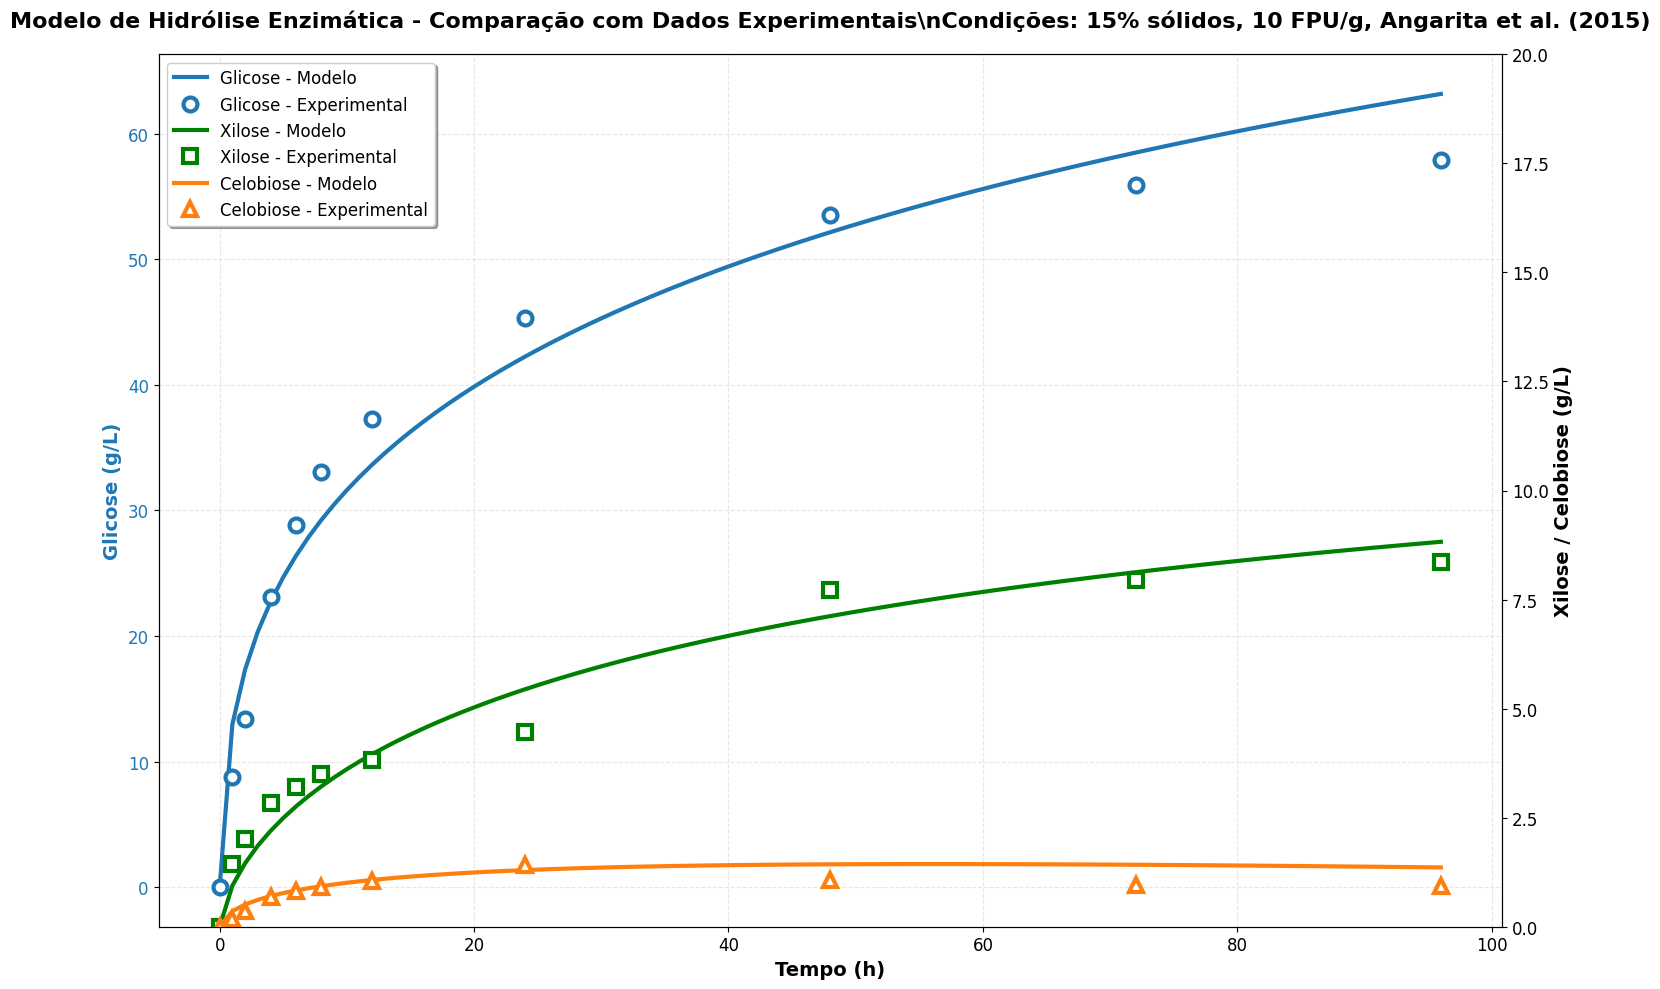


7. ANÁLISE QUANTITATIVA DOS RESULTADOS

📊 COMPARAÇÃO GLICOSE:
Tempo (h)  Exp (g/L)    Modelo (g/L)   Erro (%)  
--------------------------------------------------
1.0        8.77         12.97          47.8      
2.0        13.36        17.33          29.7      
4.0        23.09        22.71          1.6       
6.0        28.86        26.39          8.6       
8.0        33.10        29.25          11.6      
12.0       37.27        33.66          9.7       
24.0       45.35        42.25          6.8       
48.0       53.56        52.17          2.6       
72.0       55.91        58.50          4.6       
96.0       57.91        63.18          9.1       

📊 COMPARAÇÃO XILOSE:
Tempo (h)  Exp (g/L)    Modelo (g/L)   Erro (%)  
--------------------------------------------------
1.0        1.43         0.94           34.3      
2.0        2.01         1.45           27.6      
4.0        2.83         2.20           22.4      
6.0        3.20         2.76           13.8      
8.0        3.

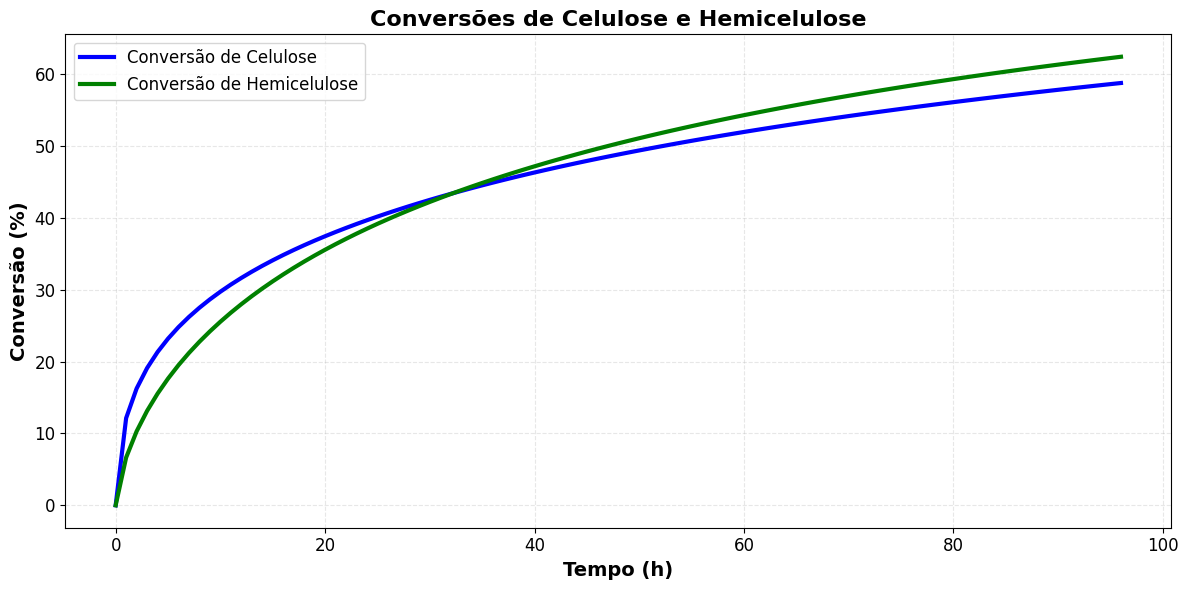


MODELO EXECUTADO COM SUCESSO! ✓


In [34]:
# ============================================================================
# MODELO COMPLETO DE HIDRÓLISE ENZIMÁTICA - EXECUÇÃO ÚNICA
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

print("=" * 80)
print("MODELO DE HIDRÓLISE ENZIMÁTICA - ANGARITA ET AL. 2015")
print("=" * 80)

# ============================================================================
# 1. CARREGAMENTO DOS DADOS EXPERIMENTAIS DO CSV
# ============================================================================
print("\n1. CARREGANDO DADOS EXPERIMENTAIS...")

try:
    df_exp = pd.read_csv('BEPE FAPESP/Dados Angarita.csv', sep=',')
    df_exp = df_exp.rename(columns=lambda x: x.strip())
    
    # Extrair dados 15%-10FPU (condição do modelo)
    tempo_exp = df_exp['Tempo [h]'].values
    glicose_exp = pd.to_numeric(df_exp['Glicose [g/L] 15%-10FPU'], errors='coerce').values
    xilose_exp = pd.to_numeric(df_exp['Xilose [g/L] 15%-10FPU'], errors='coerce').values
    celobiose_exp = pd.to_numeric(df_exp['Celobiose [g/L] 15%-10FPU'], errors='coerce').values
    
    # Limpar dados (remover NaN)
    mask_validos = ~np.isnan(glicose_exp) & ~np.isnan(xilose_exp) & ~np.isnan(celobiose_exp)
    tempo_exp = tempo_exp[mask_validos]
    glicose_exp = glicose_exp[mask_validos]
    xilose_exp = xilose_exp[mask_validos]
    celobiose_exp = celobiose_exp[mask_validos]
    
    print(f"✓ Dados 15%-10FPU carregados: {len(tempo_exp)} pontos temporais")
    
except Exception as e:
    print(f"⚠ Erro ao carregar CSV: {e}")
    print("⚠ Usando dados de fallback...")
    
    # Dados de fallback já definidos anteriormente
    tempo_exp = np.array([0, 1, 2, 4, 6, 8, 12, 24, 48, 72, 96])
    glicose_exp = np.array([0.0, 8.77, 13.36, 23.09, 28.86, 33.10, 37.27, 45.35, 53.56, 55.91, 57.91])
    celobiose_exp = np.array([0.0, 0.17, 0.37, 0.69, 0.82, 0.92, 1.05, 1.41, 1.08, 0.95, 0.93])
    xilose_exp = np.array([0.0, 1.43, 2.01, 2.83, 3.20, 3.50, 3.83, 4.46, 7.71, 7.94, 8.36])

# ============================================================================
# 2. DEFINIÇÃO DOS PARÂMETROS DO MODELO
# ============================================================================
print("\n2. DEFININDO PARÂMETROS DO MODELO...")

# Condições operacionais
S0 = 150.0                  # Carregamento de sólidos (g/L)
Cellulose = 0.66           # Fração de celulose
Hemicellulose = 0.083      # Fração de hemicelulose
Lignin = 0.257             # Fração de lignina
E_T = 0.175                # Concentração total de enzima (g/L)
alfa = 1.0                 # Fator de resistência

# Parâmetros cinéticos (Angarita et al. 2015)
k_1r = 0.177              # Taxa de reação r1 (h⁻¹)
k_2r = 8.81               # Taxa de reação r2 (h⁻¹)
k_3r = 201.0              # Taxa de reação r3 (h⁻¹)
k_4r = 16.34              # Taxa de reação r4 (h⁻¹)

# Constantes de inibição - Reação 1
k_11G2 = 0.402            # Inibição por celobiose (g/L)
k_11G = 2.71              # Inibição por glicose (g/L)
k_11X = 2.15              # Inibição por xilose (g/L)

# Constantes de inibição - Reação 2
k_21G2 = 119.6            # Inibição por celobiose (g/L)
k_21G = 4.69              # Inibição por glicose (g/L)
k_21X = 0.095             # Inibição por xilose (g/L)

# Constantes de Michaelis-Menten - Reação 3
k_3M = 26.6               # Constante de Michaelis (g/L)
k_31G = 11.06             # Inibição por glicose (g/L)
k_31X = 1.023             # Inibição por xilose (g/L)

# Constantes de inibição - Reação 4
k_41G2 = 16.25            # Inibição por celobiose (g/L)
k_41G = 4.0               # Inibição por glicose (g/L)
k_41X = 154.0             # Inibição por xilose (g/L)

# Parâmetros de adsorção enzimática
k_ad = 7.16               # Constante de adsorção
E_max = 8.32/1000         # Capacidade máxima de adsorção (g/L)

print("✓ Parâmetros definidos")

# ============================================================================
# 3. FUNÇÃO PARA CALCULAR EQUILÍBRIO ENZIMÁTICO
# ============================================================================

def calcular_enzima_equilibrio(E_T, S, E_max, k_ad):
    """Calcula enzima livre e adsorvida em equilíbrio"""
    def equation(E_F):
        E_B = E_T - E_F
        return E_max * k_ad * E_F / (1 + k_ad * E_F) - E_B / S
    
    E_F = fsolve(equation, 0.1)[0]
    E_B = E_T - E_F
    return E_F, E_B

# ============================================================================
# 4. SISTEMA DE EQUAÇÕES DIFERENCIAIS
# ============================================================================

def modelo_hidrolise(t, y):
    """
    Sistema de ODEs para hidrólise enzimática
    
    Variáveis de estado:
    y[0] = C    - Celulose (g/L)
    y[1] = G2   - Celobiose (g/L)
    y[2] = G    - Glicose (g/L)
    y[3] = H    - Hemicelulose (g/L)
    y[4] = X    - Xilose (g/L)
    y[5] = S    - Biomassa total (g/L)
    y[6] = E_B  - Enzima adsorvida (g/L)
    y[7] = E_F  - Enzima livre (g/L)
    """
    
    C, G2, G, H, X, S, E_B, E_F = y
    
    # Evitar divisão por zero
    S = max(S, 1e-6)
    
    # Fator de resistência
    R_S = alfa * S / S0
    
    # Concentrações de enzima específica
    Ebc = E_B * C / S     # Enzima específica para celulose
    Ebh = E_B * H / S     # Enzima específica para hemicelulose
    
    # Taxas de reação
    r1 = k_1r * Ebc * R_S * C / (1 + G2/k_11G2 + G/k_11G + X/k_11X)
    r2 = k_2r * Ebc * R_S * C / (1 + G2/k_21G2 + G/k_21G + X/k_21X)
    r3 = k_3r * E_F * G2 / (k_3M * (1 + G/k_31G + X/k_31X) + G2)
    r4 = k_4r * Ebh * R_S * H / (1 + G2/k_41G2 + G/k_41G + X/k_41X)
    
    # Equações diferenciais
    dCdt = -r1 - r2                 # Celulose
    dG2dt = 1.056 * r1 - r3         # Celobiose
    dGdt = 1.111 * r2 + 1.053 * r3  # Glicose
    dHdt = -r4                      # Hemicelulose
    dXdt = 1.136 * r4               # Xilose
    dSdt = -r1 - r2 - r4            # Biomassa
    
    # Enzimas (equações algébricas - derivadas = 0)
    dE_Bdt = 0
    dE_Fdt = 0
    
    return [dCdt, dG2dt, dGdt, dHdt, dXdt, dSdt, dE_Bdt, dE_Fdt]

print("\n3. SISTEMA DE ODEs DEFINIDO")

# ============================================================================
# 5. CONDIÇÕES INICIAIS E SIMULAÇÃO
# ============================================================================
print("\n4. CONFIGURANDO CONDIÇÕES INICIAIS...")

# Calcular enzimas em equilíbrio inicial
E_F_inicial, E_B_inicial = calcular_enzima_equilibrio(E_T, S0, E_max, k_ad)

# Condições iniciais
y0 = [
    S0 * Cellulose,      # Celulose inicial
    0.0,                 # Celobiose inicial
    0.0,                 # Glicose inicial
    S0 * Hemicellulose,  # Hemicelulose inicial
    0.0,                 # Xilose inicial
    S0,                  # Biomassa inicial
    E_B_inicial,         # Enzima adsorvida inicial
    E_F_inicial          # Enzima livre inicial
]

print(f"✓ Celulose inicial: {y0[0]:.2f} g/L")
print(f"✓ Hemicelulose inicial: {y0[3]:.2f} g/L")
print(f"✓ Biomassa inicial: {y0[5]:.2f} g/L")
print(f"✓ Enzima livre inicial: {y0[7]:.4f} g/L")
print(f"✓ Enzima adsorvida inicial: {y0[6]:.4f} g/L")

# Configuração da simulação
t_final = 96.0
t_pontos = np.linspace(0, t_final, 97)

print("\n5. EXECUTANDO SIMULAÇÃO...")

# Resolver sistema de ODEs
sol = solve_ivp(modelo_hidrolise, [0, t_final], y0, t_eval=t_pontos, method='LSODA', rtol=1e-8)

if sol.success:
    print("✓ Simulação concluída com sucesso")
    
    # Extrair resultados
    t_sim = sol.t
    C_sim = sol.y[0]     # Celulose
    G2_sim = sol.y[1]    # Celobiose
    G_sim = sol.y[2]     # Glicose
    H_sim = sol.y[3]     # Hemicelulose
    X_sim = sol.y[4]     # Xilose
    S_sim = sol.y[5]     # Biomassa
    EB_sim = sol.y[6]    # Enzima adsorvida
    EF_sim = sol.y[7]    # Enzima livre
    
else:
    print("✗ Erro na simulação:", sol.message)

# ============================================================================
# 6. PLOTAGEM DOS RESULTADOS
# ============================================================================
print("\n6. GERANDO GRÁFICOS...")

# Criar figura principal
fig, ax1 = plt.subplots(figsize=(15, 10))

# Glicose no eixo esquerdo
ax1.plot(t_sim, G_sim, '-', label='Glicose - Modelo', color='tab:blue', linewidth=3)
ax1.plot(tempo_exp, glicose_exp, 'o', label='Glicose - Experimental', 
         color='tab:blue', markersize=10, markerfacecolor='white', 
         markeredgewidth=3, markeredgecolor='tab:blue')

ax1.set_xlabel('Tempo (h)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Glicose (g/L)', color='tab:blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')

# Xilose e Celobiose no eixo direito
ax2 = ax1.twinx()

ax2.plot(t_sim, X_sim, '-', label='Xilose - Modelo', color='green', linewidth=3)
ax2.plot(tempo_exp, xilose_exp, 's', label='Xilose - Experimental', 
         color='green', markersize=10, markerfacecolor='white', 
         markeredgewidth=3, markeredgecolor='green')

ax2.plot(t_sim, G2_sim, '-', label='Celobiose - Modelo', color='tab:orange', linewidth=3)
ax2.plot(tempo_exp, celobiose_exp, '^', label='Celobiose - Experimental', 
         color='tab:orange', markersize=10, markerfacecolor='white', 
         markeredgewidth=3, markeredgecolor='tab:orange')

ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=12)
ax2.set_ylim(0, 20)

# Legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
           fontsize=12, frameon=True, fancybox=True, shadow=True)

plt.title('Modelo de Hidrólise Enzimática - Comparação com Dados Experimentais\\n' +
          'Condições: 15% sólidos, 10 FPU/g, Angarita et al. (2015)', 
          fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. ANÁLISE QUANTITATIVA
# ============================================================================
print("\n7. ANÁLISE QUANTITATIVA DOS RESULTADOS")
print("=" * 60)

# Interpolar modelo nos tempos experimentais
G_modelo_interp = np.interp(tempo_exp, t_sim, G_sim)
X_modelo_interp = np.interp(tempo_exp, t_sim, X_sim)
G2_modelo_interp = np.interp(tempo_exp, t_sim, G2_sim)

# Tabela de comparação - Glicose
print("\n📊 COMPARAÇÃO GLICOSE:")
print(f"{'Tempo (h)':<10} {'Exp (g/L)':<12} {'Modelo (g/L)':<14} {'Erro (%)':<10}")
print("-" * 50)
erros_G = []
for i in range(len(tempo_exp)):
    if glicose_exp[i] > 0:
        erro = abs(G_modelo_interp[i] - glicose_exp[i]) / glicose_exp[i] * 100
        erros_G.append(erro)
        print(f"{tempo_exp[i]:<10.1f} {glicose_exp[i]:<12.2f} {G_modelo_interp[i]:<14.2f} {erro:<10.1f}")

# Tabela de comparação - Xilose
print("\n📊 COMPARAÇÃO XILOSE:")
print(f"{'Tempo (h)':<10} {'Exp (g/L)':<12} {'Modelo (g/L)':<14} {'Erro (%)':<10}")
print("-" * 50)
erros_X = []
for i in range(len(tempo_exp)):
    if xilose_exp[i] > 0:
        erro = abs(X_modelo_interp[i] - xilose_exp[i]) / xilose_exp[i] * 100
        erros_X.append(erro)
        print(f"{tempo_exp[i]:<10.1f} {xilose_exp[i]:<12.2f} {X_modelo_interp[i]:<14.2f} {erro:<10.1f}")

# Estatísticas finais
print("\n📈 ESTATÍSTICAS DO MODELO:")
print(f"Erro médio absoluto - Glicose: {np.mean(erros_G):.1f}%")
print(f"Erro médio absoluto - Xilose: {np.mean(erros_X):.1f}%")
print(f"Conversão final de celulose: {(1 - C_sim[-1]/(S0*Cellulose))*100:.1f}%")
print(f"Conversão final de hemicelulose: {(1 - H_sim[-1]/(S0*Hemicellulose))*100:.1f}%")
print(f"Concentração final de glicose: {G_sim[-1]:.2f} g/L")
print(f"Concentração final de xilose: {X_sim[-1]:.2f} g/L")

# ============================================================================
# 8. GRÁFICO ADICIONAL - CONVERSÕES
# ============================================================================

# Gráfico de conversões
plt.figure(figsize=(12, 6))

conv_celulose = (1 - C_sim / (S0 * Cellulose)) * 100
conv_hemicelulose = (1 - H_sim / (S0 * Hemicellulose)) * 100

plt.plot(t_sim, conv_celulose, 'b-', linewidth=3, label='Conversão de Celulose')
plt.plot(t_sim, conv_hemicelulose, 'g-', linewidth=3, label='Conversão de Hemicelulose')

plt.xlabel('Tempo (h)', fontsize=14, fontweight='bold')
plt.ylabel('Conversão (%)', fontsize=14, fontweight='bold')
plt.title('Conversões de Celulose e Hemicelulose', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("MODELO EXECUTADO COM SUCESSO! ✓")
print("=" * 80)